In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib


In [2]:
df = pd.read_csv(r"D:\final data_set.zip")
df.head()


,1/1/2014,1/2/2014,1/3/2014,1/4/2014,1/5/2014,1/6/2014,1/7/2014,1/8/2014,1/9/2014,1/10/2014,...,10/24/2016,10/25/2016,10/26/2016,10/27/2016,10/28/2016,10/29/2016,10/30/2016,10/31/2016,CONS_NO,FLAG
0,0.0,0.0,0.01,0.0,0.0,0.00,0.00,0.00,0.00,0.00,...,0.02,0.06,0.58,0.89,0.35,0.38,0.70,0.25,0387DD8A07E07FDA6271170F86AD9151,1
1,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,...,17.13,14.32,16.37,26.33,19.06,17.38,13.94,14.14,01D6177B5D4FFE0CABA9EF17DAFC2B84,1
2,0.0,0.0,0.00,0.0,0.0,4.98,9.87,11.29,13.44,11.34,...,4.29,1.43,2.22,2.41,3.48,2.89,1.88,1.16,4B75AC4F2D8434CFF62DB64D0BB43103,1
3,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,...,20.98,18.47,15.50,14.80,19.28,16.10,17.51,16.67,B32AC8CC6D5D805AC053557AB05F5343,1
4,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,...,0.61,1.33,0.55,1.62,1.53,2.10,1.16,2.13,EDFC78B07BA2908B3395C4EB2304665E,1


In [3]:
df.info()
df.describe().T
df.isna().sum()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42372 entries, 0 to 42371
Columns: 1036 entries, 1/1/2014 to FLAG
dtypes: float64(1034), int64(1), object(1)
memory usage: 334.9+ MB


1/1/2014      0
1/2/2014      0
1/3/2014      0
1/4/2014      0
1/5/2014      0
             ..
10/29/2016    0
10/30/2016    0
10/31/2016    0
CONS_NO       0
FLAG          0
Length: 1036, dtype: int64

In [4]:

num_cols = df.select_dtypes(include=[np.number]).columns

df[num_cols] = df[num_cols].fillna(df[num_cols].median())


In [5]:
scaler = StandardScaler()
X = scaler.fit_transform(df[num_cols])
joblib.dump(scaler, "scaler.joblib")


['scaler.joblib']

In [6]:
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)


In [7]:
iso = IsolationForest(
    n_estimators=200,
    contamination=0.01,
    random_state=42
)

iso.fit(X_train)
joblib.dump(iso, "theft_detection_model.joblib")


['theft_detection_model.joblib']

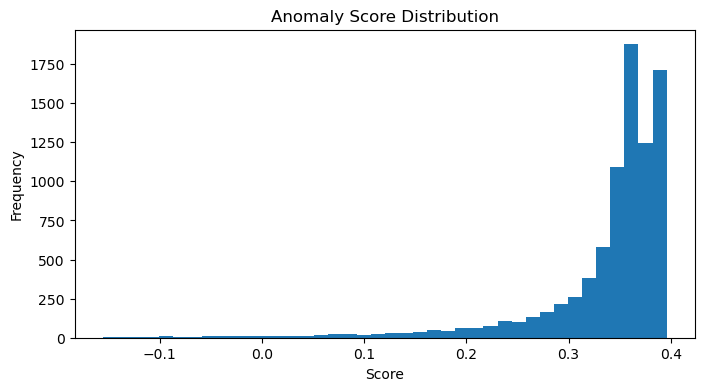

In [8]:
scores = iso.decision_function(X_test)

plt.figure(figsize=(8,4))
plt.hist(scores, bins=40)
plt.title("Anomaly Score Distribution")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.show()


In [9]:
preds = iso.predict(X_test)   
anomalies = preds == -1

print("Number of anomalies:", anomalies.sum())


Number of anomalies: 79


In [10]:
anomaly_idx = np.where(anomalies)[0]
anomaly_idx[:10]  


array([ 88, 184, 192, 311, 325, 405, 434, 504, 616, 743], dtype=int64)

In [12]:
# Take an existing row from the dataset
sample = df[num_cols].iloc[0].copy()


In [13]:
new_data = np.array([sample.values])


In [15]:
scaled = scaler.transform(new_data)
pred = iso.predict(scaled)[0]
score = iso.decision_function(scaled)[0]

print("Prediction:", "Anomaly" if pred == -1 else "Normal")
print("Score:", score)


Prediction: Normal
Score: 0.3326498524512617


C:\Users\gurum\anaconda3\py anaconda\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [16]:
def predict_anomaly(row):
    scaled = scaler.transform([row.values])
    pred = iso.predict(scaled)[0]
    score = iso.decision_function(scaled)[0]
    return "Anomaly" if pred == -1 else "Normal", score


In [17]:
predict_anomaly(sample)


C:\Users\gurum\anaconda3\py anaconda\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


('Normal', 0.3326498524512617)

In [19]:
df["prediction"] = iso.predict(scaler.transform(df[num_cols]))
df["score"] = iso.decision_function(scaler.transform(df[num_cols]))


C:\Users\gurum\AppData\Local\Temp\ipykernel_22240\522024597.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["prediction"] = iso.predict(scaler.transform(df[num_cols]))
C:\Users\gurum\AppData\Local\Temp\ipykernel_22240\522024597.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["score"] = iso.decision_function(scaler.transform(df[num_cols]))


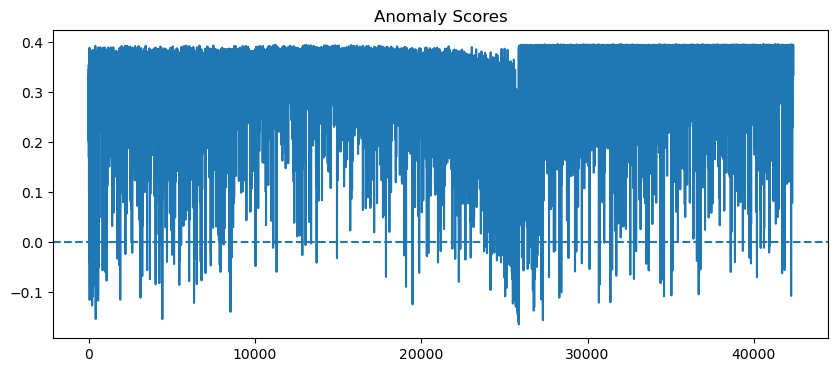

In [20]:
plt.figure(figsize=(10,4))
plt.plot(df["score"])
plt.axhline(0, linestyle="--")
plt.title("Anomaly Scores")
plt.show()


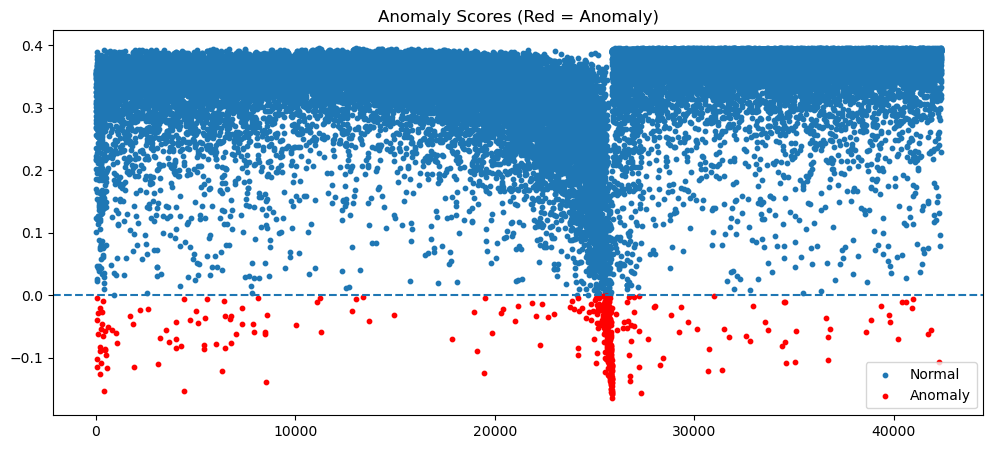

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

scores = df["score"]
anomalies = df["prediction"] == -1

plt.scatter(df.index[~anomalies], scores[~anomalies], label="Normal", s=10)
plt.scatter(df.index[anomalies], scores[anomalies], label="Anomaly", s=10, color="red")

plt.axhline(0, linestyle="--")
plt.title("Anomaly Scores (Red = Anomaly)")
plt.legend()
plt.show()


In [22]:
anomaly_rows = df[df["prediction"] == -1]
anomaly_rows.head()


,1/1/2014,1/2/2014,1/3/2014,1/4/2014,1/5/2014,1/6/2014,1/7/2014,1/8/2014,1/9/2014,1/10/2014,...,10/26/2016,10/27/2016,10/28/2016,10/29/2016,10/30/2016,10/31/2016,CONS_NO,FLAG,prediction,score
40,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,31.20,39.10,50.50,56.30,43.20,33.30,1BC425A74948B48CED2DD171224E219C,1,-1,-0.039555
50,0.0,107.2,97.80,85.40,0.00,0.00,0.00,0.00,0.00,0.00,...,93.60,137.00,113.40,95.30,68.10,51.20,522CD12E4FD07B23C55E2E2F475D4AB0,1,-1,-0.102642
56,0.0,0.0,173.06,187.91,197.53,190.47,179.57,184.65,183.82,177.57,...,126.65,146.29,133.84,121.65,99.43,97.34,4BA0F954979FABF38CF0C6CDDD4EBBDC,1,-1,-0.115479
80,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,377.31,368.42,342.22,380.98,251.11,6.38,1C00BB2E851B50CF3DA33517F71D23C5,1,-1,-0.003669
108,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,75.85,73.64,85.79,75.94,72.43,82.13,86389EE6F32A43F90209F552BB623254,1,-1,-0.061587


In [23]:
df["prediction"].value_counts()


prediction
 1    41954
-1      418
Name: count, dtype: int64

In [24]:
df.to_csv("anomaly_results.csv", index=False)


In [25]:
import joblib
joblib.dump(scaler, "scaler.pkl")
joblib.dump(iso, "isolation_forest.pkl")


['isolation_forest.pkl']